In [1]:
from nlp import load_dataset, Dataset
import pandas as pd
import re
from transformers import Trainer, TrainingArguments, DistilBertForSequenceClassification, DistilBertTokenizerFast
from datasets import load_metric
import numpy as np
from torch.nn import Softmax
from torch.utils.data import DataLoader
from torch import argmax


In [2]:
# # Ingest tweets from the Kaggle Corona Sentiment tweet comopetition

# tweets = pd.read_csv('../data/corona_sentiment.csv', encoding='ISO-8859-1')

# print(tweets.shape)
# tweets = tweets[(tweets['OriginalTweet'].str.len() > 30) & (tweets['OriginalTweet'].str.len() < 200)]
# tweets.dropna(subset=['OriginalTweet'], inplace=True)
# tweets = tweets[~tweets['OriginalTweet'].isnull()]

# print(tweets.shape)
# tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# tweets.index = tweets['date']
# del tweets['date']

# tweets.sort_index(inplace=True)

# tweets['month'] = tweets.index.month
# tweets = pd.concat([tweets[tweets['month'] != 3], tweets[tweets['month'] == 3].sample(2000)])

# tweets['month'].value_counts().sort_index().plot(kind='bar')

# tweets.to_csv('../data/tweets_sample.csv', index=False, encoding='ISO-8859-1')

# tweets.head()


In [3]:
# read in our tweet sample
tweets = pd.read_csv('../data/tweets_sample.csv', encoding='ISO-8859-1')

# convert the date to a datetime format
tweets['date'] = pd.to_datetime(tweets['TweetAt']).astype('datetime64[ms]')

# set our index as our datetime column and delete the date columns
tweets.index = tweets['date']
del tweets['date']

# Sort our tweets
tweets.sort_index(inplace=True)

tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month
date,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1
2020-01-04,29313,74265,NaN,01-04-2020,Webinar 4 2 3 30p ET Navigating Today s Market...,Neutral,1
2020-01-04,29314,74266,Edmonton,01-04-2020,The provincial government is increasing its fo...,Negative,1
2020-01-04,29315,74267,News & Bible verses USA,01-04-2020,Coronavirus: Oil prices could turn negative as...,Negative,1
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1


<AxesSubplot:>

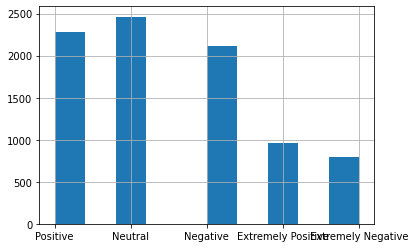

In [4]:
tweets['Sentiment'].hist()

In [5]:
tweets.dropna(inplace=True)
tweets.shape

(6842, 7)

In [6]:
URL_REGEX = re.compile('http(s)?:\/\/t.co\/\w+')
MENTION_REGEX = re.compile('@\w+')

def clean_tweet(tweet):
    # remove mentions, the pound sign, and replace urls with URL token
    tweet = re.sub(URL_REGEX, 'url', tweet)  # replace urls with url. Assumes that the mention of a url is significant
    tweet = re.sub(MENTION_REGEX, '', tweet)  # remove mentions entirely
    tweet = tweet.replace('#', '')  # remove pound signs
    
    return tweet.strip()

clean_tweet(tweets['OriginalTweet'].iloc[0])


'Overwhelmed with info Before you act stop Ask yourself 1 Who is the message from 2 What do they want me to do 3 What evidence supports this message Then let the answers guide your next steps More via'

In [7]:
tweets.shape

(6842, 7)

In [8]:
tweets = tweets[~tweets['OriginalTweet'].isnull()]

In [9]:
tweets['text'] = tweets['OriginalTweet'].apply(clean_tweet)

tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text
date,,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...
2020-01-04,29314,74266,Edmonton,01-04-2020,The provincial government is increasing its fo...,Negative,1,The provincial government is increasing its fo...
2020-01-04,29315,74267,News & Bible verses USA,01-04-2020,Coronavirus: Oil prices could turn negative as...,Negative,1,Coronavirus: Oil prices could turn negative as...
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1,Malwarebytes rounded up some useful tips for s...
2020-01-04,29317,74269,Australia,01-04-2020,A Queensland mum has posted a heartbreaking pi...,Extremely Negative,1,A Queensland mum has posted a heartbreaking pi...


In [10]:
tweets['sentiment'] = tweets['Sentiment'].map({
    'Extremely Negative': 0,
    'Negative': 0,
    'Neutral': 1,
    'Positive': 2,
    'Extremely Positive': 2
})

<AxesSubplot:>

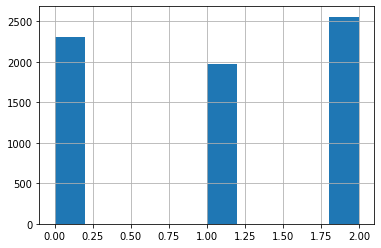

In [11]:
tweets['sentiment'].hist()

<AxesSubplot:>

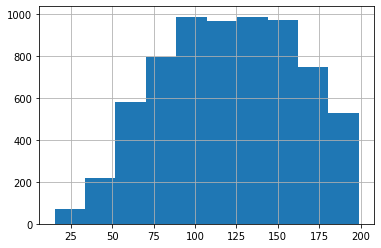

In [12]:
tweets['text'].apply(len).hist()

<AxesSubplot:xlabel='date'>

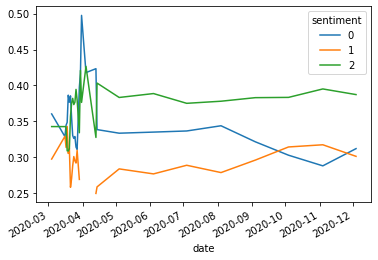

In [13]:
tweets.groupby('date')['sentiment'].value_counts(normalize=True).unstack().rolling(3).mean().plot()

In [14]:
# the trainer is expecting a 'label' (see the forward method in the docs)
tweets['label'] = tweets['sentiment']

In [15]:
training_tweets = tweets[:'2020-03']
training_tweets.reset_index(inplace=True)
training_tweets.tail()


,date,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,sentiment,label
2152,2020-03-31,29068,74020,"New York, NY",31-03-2020,"What this says to me is that so far, the fallo...",Negative,3,"What this says to me is that so far, the fallo...",0,0
2153,2020-03-31,28990,73942,Australia,31-03-2020,#Wasteful panic-buyers are throwing away perfe...,Positive,3,Wasteful panic-buyers are throwing away perfec...,2,2
2154,2020-03-31,29252,74204,Washington,31-03-2020,A weird consequence of the #coronavirus pandem...,Negative,3,A weird consequence of the coronavirus pandemi...,0,0
2155,2020-03-31,29276,74228,"Geneva, Switzerland",31-03-2020,EuropeÂs fresh food supply is being threatene...,Negative,3,EuropeÂs fresh food supply is being threatene...,0,0
2156,2020-03-31,29047,73999,Hogwarts,31-03-2020,Online-shopping without actually being able to...,Neutral,3,Online-shopping without actually being able to...,1,1


In [16]:

tweet_dataset = Dataset.from_pandas(training_tweets[['text', 'label']])

# Dataset has a built in train test split method
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)

train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
tweets.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,sentiment,label
date,,,,,,,,,,
2020-01-04,29309,74261,"Tidal County, Knoxville, TN",01-04-2020,Overwhelmed with info Before you act stop Ask ...,Positive,1,Overwhelmed with info Before you act stop Ask ...,2,2
2020-01-04,29314,74266,Edmonton,01-04-2020,The provincial government is increasing its fo...,Negative,1,The provincial government is increasing its fo...,0,0
2020-01-04,29315,74267,News & Bible verses USA,01-04-2020,Coronavirus: Oil prices could turn negative as...,Negative,1,Coronavirus: Oil prices could turn negative as...,0,0
2020-01-04,29316,74268,"Fort George G. Meade, Md.",01-04-2020,Malwarebytes rounded up some useful tips for s...,Extremely Positive,1,Malwarebytes rounded up some useful tips for s...,2,2
2020-01-04,29317,74269,Australia,01-04-2020,A Queensland mum has posted a heartbreaking pi...,Extremely Negative,1,A Queensland mum has posted a heartbreaking pi...,0,0


In [18]:
BERT_MODEL = 'distilbert-base-uncased'

if 'distilbert' in BERT_MODEL:
    bert_tokenizer = DistilBertTokenizerFast.from_pretrained(BERT_MODEL)
else:
    bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

In [19]:
# We will pad our dataset so that our input matrices are the same length and truncate anything longer than 512 tokens
def preprocess(data):
    return bert_tokenizer(data['text'], padding=True, truncation=True, max_length=128)

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [20]:
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    BERT_MODEL, num_labels=3,
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False # Whether the model returns all hidden-states.
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

In [21]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [22]:
len(train_set)

1725

In [23]:
batch_size = 64
epochs = 4

warmup_steps = len(train_set) // 5
weight_decay = 0.05

training_args = TrainingArguments(
    output_dir='./clf/results',
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    warmup_steps=warmup_steps,
    weight_decay=weight_decay,
    logging_dir='./clf/logs',
    logging_strategy='epoch',
    logging_first_step=True,
)

# Define the trainer: 

trainer = Trainer(
    model=sequence_classification_model,
    args=training_args,
    train_dataset=train_set,
    eval_dataset=test_set,
    compute_metrics=compute_metrics
)

In [24]:
Softmax(dim=1)(sequence_classification_model(
    bert_tokenizer.encode(clean_tweet('Corona Virus sucks so bad'), return_tensors='pt')).logits)

tensor([[0.3472, 0.3176, 0.3351]], grad_fn=<SoftmaxBackward0>)

In [67]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 432
  Batch size = 64


{'eval_loss': 1.1131409406661987,
 'eval_accuracy': 0.3148148148148148,
 'eval_runtime': 3.0531,
 'eval_samples_per_second': 141.496,
 'eval_steps_per_second': 2.293}

In [76]:
trainer.train()

***** Running training *****
  Num examples = 1725
  Num Epochs = 2
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 54


Step,Training Loss
1,1.054400
27,1.053000
54,0.918600




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=54, training_loss=0.9858510582535355, metrics={'train_runtime': 162.9347, 'train_samples_per_second': 21.174, 'train_steps_per_second': 0.331, 'total_flos': 86583995169300.0, 'train_loss': 0.9858510582535355, 'epoch': 2.0})

In [77]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 432
  Batch size = 64


{'eval_loss': 0.8735637068748474,
 'eval_accuracy': 0.6203703703703703,
 'eval_runtime': 3.156,
 'eval_samples_per_second': 136.881,
 'eval_steps_per_second': 2.218,
 'epoch': 2.0}

In [78]:
Softmax(dim=1)(sequence_classification_model(
    bert_tokenizer.encode(clean_tweet('Corona Virus sucks so bad'), return_tensors='pt')).logits)

tensor([[0.3692, 0.2859, 0.3449]], grad_fn=<SoftmaxBackward0>)

In [79]:
trainer.save_model()

Saving model checkpoint to ./clf/results
Configuration saved in ./clf/results/config.json
Model weights saved in ./clf/results/pytorch_model.bin


In [25]:
sequence_classification_model = DistilBertForSequenceClassification.from_pretrained(
    './clf/results', num_labels=3
)
sequence_classification_model.eval()

print('ready for eval')

loading configuration file ./clf/results/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.13.0",
  "vocab_size": 30522
}

loading weights file ./clf/results/pytorch_model.bin
All model checkpoint weights were used when initializing DistilBertForSequenceClassification.


ready for eval


In [26]:
import gc

# My mac is a new one running Monterey and memory leaks are unfortunately a problem
def garbage(debug=False):
    if debug:
        print(gc.get_count())
    gc.collect()
    if debug:
        print(gc.get_count())

In [28]:
garbage(debug=True)

(91, 0, 0)
(35, 0, 0)


In [27]:
from tqdm import tqdm

tweets['predicted_label'] = None

for month in tqdm(range(4, 13)):
    tweets.loc[f'2020-{month}', 'predicted_label'] = sequence_classification_model(
        **bert_tokenizer.batch_encode_plus(tweets.loc[f'2020-{month}']['text'].tolist(), return_tensors='pt', padding=True)
    ).logits.argmax(1)
    garbage()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:58<00:00,  6.48s/it]


In [28]:
tweets.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,month,text,sentiment,label,predicted_label
date,,,,,,,,,,,
2020-12-04,42697,87649,"Houston, TX",12-04-2020,Why does feel so bad right now via,Extremely Negative,12,Why does feel so bad right now via,0,0,0
2020-12-04,42696,87648,"Columbia,SC",12-04-2020,Lessons Learned 21 Days Of COVID 19 Crisis Com...,Extremely Negative,12,Lessons Learned 21 Days Of COVID 19 Crisis Com...,0,0,0
2020-12-04,42648,87600,"Doha-Washington, DC",12-04-2020,WEBINAR. The GCCÂs double dilemma: Tackling C...,Negative,12,WEBINAR. The GCCÂs double dilemma: Tackling C...,0,0,0
2020-12-04,42706,87658,United States,12-04-2020,#SocialDistancing save lives. Thanks to all fr...,Extremely Positive,12,SocialDistancing save lives. Thanks to all fro...,2,2,2
2020-12-04,43110,88062,"Hyderabad, Andhra Pradesh",12-04-2020,@hydcitypolice outside Manasarovar heights pha...,Negative,12,outside Manasarovar heights phase 3 opposite U...,0,0,1


In [29]:
tweets['correct_label'] = tweets['predicted_label'] == tweets['label']

tweets.groupby('month')['correct_label'].mean()

month
1     0.000000
2     0.000000
3     0.000000
4     0.637088
5     0.628866
6     0.591433
7     0.580189
8     0.662687
9     0.630859
10    0.627660
11    0.642643
12    0.651408
Name: correct_label, dtype: float64

<AxesSubplot:xlabel='month'>

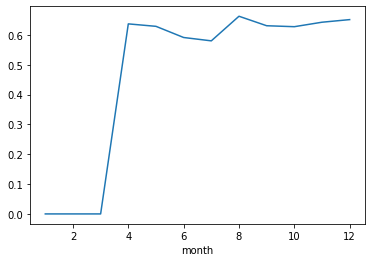

In [30]:
tweets.groupby('month')['correct_label'].mean().plot()

In [35]:
training_tweets = tweets['2020-04']

tweet_dataset = Dataset.from_pandas(training_tweets.reset_index()[['text', 'label']])
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)
train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


training_args.warmup_steps = 0

# Define the trainer: 

trainer.train_dataset=train_set
trainer.eval_dataset=test_set

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_12286/2280951424.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  training_tweets = tweets['2020-04']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 176
  Batch size = 64


{'eval_loss': 0.8849554657936096,
 'eval_accuracy': 0.6136363636363636,
 'eval_runtime': 1.281,
 'eval_samples_per_second': 137.388,
 'eval_steps_per_second': 2.342}

In [37]:
trainer.train()

***** Running training *****
  Num examples = 703
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 44


Step,Training Loss
1,0.790500
11,0.848100
22,0.566800
33,0.401900
44,0.308200




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=44, training_loss=0.5299697111953389, metrics={'train_runtime': 69.9519, 'train_samples_per_second': 40.199, 'train_steps_per_second': 0.629, 'total_flos': 40742730874944.0, 'train_loss': 0.5299697111953389, 'epoch': 4.0})

In [38]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 176
  Batch size = 64


{'eval_loss': 0.716437816619873,
 'eval_accuracy': 0.7386363636363636,
 'eval_runtime': 1.2397,
 'eval_samples_per_second': 141.971,
 'eval_steps_per_second': 2.42,
 'epoch': 4.0}

In [39]:
from tqdm import tqdm

tweets['predicted_label_trained_at_4'] = None

for month in tqdm(range(5, 13)):
    tweets.loc[f'2020-{month}', 'predicted_label_trained_at_4'] = sequence_classification_model(
        **bert_tokenizer.batch_encode_plus(tweets.loc[f'2020-{month}']['text'].tolist(), return_tensors='pt', padding=True)
    ).logits.argmax(1)
    garbage()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:52<00:00,  6.51s/it]


<AxesSubplot:xlabel='month'>

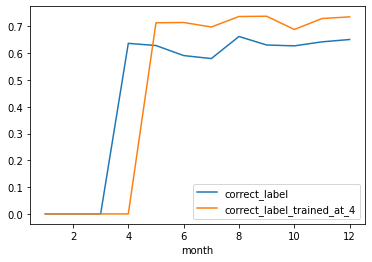

In [44]:
tweets['correct_label_trained_at_4'] = tweets['predicted_label_trained_at_4'] == tweets['label']

tweets.groupby('month')[['correct_label', 'correct_label_trained_at_4']].mean().plot()

In [45]:
training_tweets = tweets['2020-05']

tweet_dataset = Dataset.from_pandas(training_tweets.reset_index()[['text', 'label']])
tweet_dataset = tweet_dataset.train_test_split(test_size=0.2)
train_set = tweet_dataset['train']
test_set = tweet_dataset['test']

train_set = train_set.map(preprocess, batched=True, batch_size=len(train_set))
test_set = test_set.map(preprocess, batched=True, batch_size=len(test_set))

train_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_set.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])


training_args.warmup_steps = 0

# Define the trainer: 

trainer.train_dataset=train_set
trainer.eval_dataset=test_set

/var/folders/y9/9xqbqkg90tnc0cmm0dxt985m0000gn/T/ipykernel_12286/4065301163.py:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  training_tweets = tweets['2020-05']


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [46]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 78
  Batch size = 64


{'eval_loss': 0.8793441653251648,
 'eval_accuracy': 0.717948717948718,
 'eval_runtime': 0.5318,
 'eval_samples_per_second': 146.674,
 'eval_steps_per_second': 3.761,
 'epoch': 4.0}

In [47]:
trainer.train()

***** Running training *****
  Num examples = 310
  Num Epochs = 4
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 20


Step,Training Loss
1,0.454300
5,0.830600
10,0.773000
15,0.727900
20,0.722700




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=20, training_loss=0.7447417467832566, metrics={'train_runtime': 37.9783, 'train_samples_per_second': 32.65, 'train_steps_per_second': 0.527, 'total_flos': 22457764173600.0, 'train_loss': 0.7447417467832566, 'epoch': 4.0})

In [48]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 78
  Batch size = 64


{'eval_loss': 0.8793441653251648,
 'eval_accuracy': 0.717948717948718,
 'eval_runtime': 0.4971,
 'eval_samples_per_second': 156.9,
 'eval_steps_per_second': 4.023,
 'epoch': 4.0}

In [49]:
from tqdm import tqdm

tweets['predicted_label_trained_at_5'] = None

for month in tqdm(range(6, 13)):
    tweets.loc[f'2020-{month}', 'predicted_label_trained_at_5'] = sequence_classification_model(
        **bert_tokenizer.batch_encode_plus(tweets.loc[f'2020-{month}']['text'].tolist(), return_tensors='pt', padding=True)
    ).logits.argmax(1)
    garbage()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:45<00:00,  6.50s/it]


<AxesSubplot:xlabel='month'>

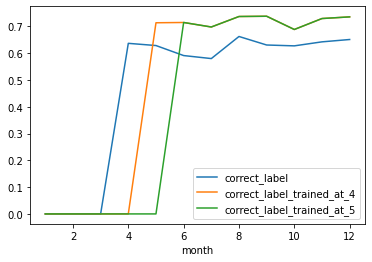

In [50]:
# Online training is not a panacea, sorry
tweets['correct_label_trained_at_5'] = tweets['predicted_label_trained_at_5'] == tweets['label']

tweets.groupby('month')[['correct_label', 'correct_label_trained_at_4', 'correct_label_trained_at_5']].mean().plot()

In [29]:
from scipy.special import kl_div


In [30]:
# remove the classifier
bert_section = sequence_classification_model.distilbert

In [31]:
four_embeddings = bert_section(
    **bert_tokenizer.batch_encode_plus(tweets[tweets.index.month == 4]['text'].tolist(), return_tensors='pt', padding=True)
).last_hidden_state


In [49]:
four_embeddings.shape

torch.Size([879, 56, 768])

<AxesSubplot:>

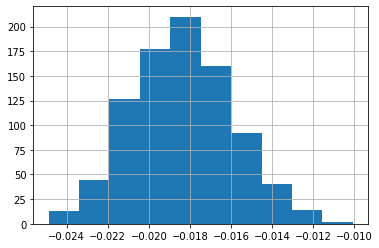

In [50]:
pd.Series(four_embeddings[:,0,:].mean(dim=1).tolist()).hist()

In [33]:
five_embeddings = bert_section(
    **bert_tokenizer.batch_encode_plus(tweets[tweets.index.month == 5]['text'].tolist(), return_tensors='pt', padding=True)
).last_hidden_state


In [51]:
five_embeddings.shape

torch.Size([388, 70, 768])

<AxesSubplot:>

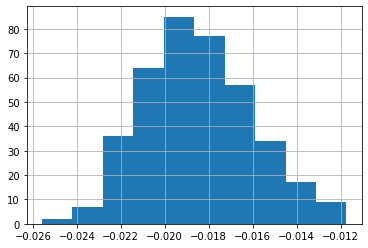

In [52]:
pd.Series(five_embeddings[:,0,:].mean(dim=1).tolist()).hist()

In [58]:
tweets['text'].str.lower().str.contains('variant').groupby(tweets.index.month).sum()

date
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
Name: text, dtype: int64

In [ ]:
# word count changes by month

In [ ]:
# online train every month, measure accuracy
# highlight changes in text where there are dropoffs
# KL tests for disitribution to maybe be lagging indicator?